<a href="https://colab.research.google.com/github/aakhterov/ML_projects/blob/master/machine_translation/machine_translation_with_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Description

We're going to build an NN model to translate from Russian to English. This notebook is committed to the implementation of the simple encoder-decoder network with LSTM elements.

We will use the following terms:
- source language - the language from which the model translates
- target language - the language to which the model translates
- token = word


Dataset: https://www.kaggle.com/datasets/hijest/englishrussian-dictionary-for-machine-translate/

References:
- https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/21_Machine_Translation.ipynb
- https://www.youtube.com/watch?v=vI2Y3I-JI2Q
- https://medium.com/analytics-vidhya/encoder-decoder-seq2seq-models-clearly-explained-c34186fbf49b



In [1]:
from typing import List
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from string import punctuation
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive


# 1. Vectorization

In [2]:
UNKNOWN_TOKEN = '[UNK]' # Out of vocabulary token
START_TOKEN = '[START]' # The token that denotes the beginning of the target language phrase
END_TOKEN = '[END]' # The token that denotes the end of the target language phrase

In [3]:
class Vectorization:
  '''
    Vectorization text class.
    Main goals:
     - make a vocabulary
     - convert the list of strings to the list of integer tokens
     - convert the list of integer tokens to the list of strings
  '''

  def __init__(self,
               max_tokens,
               max_length=None,
               unknown_token=UNKNOWN_TOKEN,
               start_token=START_TOKEN,
               end_token=END_TOKEN
               ):
    '''
      :param max_tokens: length of the vocabulary
      :param max_length: max length of the phrases
      :param unknown_token: out of vocabulary token
      :param start_token: token that denotes the beginning of the phrase
      :param end_token: token that denotes the end of the phrase
    '''
    self.max_tokens = max_tokens
    self.max_length = max_length
    self.unknown_token = unknown_token
    self.start_token = start_token
    self.end_token=end_token
    # add to the vocabulary:
    #  (1) padding token (we're going to pad using 0, so padding token index is 0)
    #  (2) out of vocabulary token
    #  (3) start token
    #  (4) end token
    self.vocabulary = ['', self.unknown_token, self.start_token, self.end_token]

  def __preprocessing(self, input: str) -> str:
    '''
      Preprocess of the string (convert to lowcase and remove punctuation).
      ex.: I'm going! -> i m going
      :param input - input string
      :return preprocessed string
    '''
    output = ''.join(map(lambda ch: ch if ch not in punctuation else ' ', input.lower())).strip()
    return output

  def token_to_text(self, tokens: List) -> str:
    '''
      Convert the list of the integer tokens to the string
      :param tokens: list of the integer tokens
      :return string contains words that correspond to the integer tokens
    '''
    words = [self.vocabulary[token] for token in tokens]
    return " ".join(words)

  def fit(self, X: List):
    '''
      Make the vocabulary and calculate the max length of the phrase
      :param X: corpus - list of the strings
      :return the instance of the current class
    '''
    lens = []
    for x in X:
      # Make preprocessing and get the list of the words.
      # Ex. I'm going! -> ['i', 'm', 'going']
      words = self.__preprocessing(x).split()

      # Collect phrases lengths
      lens.append(len(words))

      # Make the vocabulary
      for word in words:
        token = word.strip()
        # Add the word to the vocabulary if it usn't "full"
        if token not in self.vocabulary and self.max_tokens is not None and len(self.vocabulary)<self.max_tokens:
          self.vocabulary.append(token)

    # Calculate the max length of the phrases if it isn't set in the __init__
    # max_length = Average length + two standard devations
    lens = np.array(lens)
    if self.max_length is None:
      self.max_length = int(np.mean(lens) + 2 * np.std(lens))
    return self

  def predict(self,
              X: List[str],
              is_padding=True,
              is_add_start_token=False,
              is_add_end_token=False
              ) -> List[List]:
    '''
      :param X - corpus - list of the strings
      :param is_padding - whether to pad the list of tokens to the max. length with 0s
      :param is_add_start_token - whether to add the start_token to the list of tokens
      :param is_add_end_token - whether to add the end_token to the list of tokens
      :return list of the lists of tokens
    '''
    output = []
    for x in X:
      # If nedded add the index of the start_token to the beginning of the list of tokens
      vector = [self.vocabulary.index(self.start_token)] if is_add_start_token else []

      # Make preprocessing and get the list of the words.
      words = self.__preprocessing(x).split()

      # If the current word is in the vocabulary add its index to the list else add the index of the unknown_token
      for word in words:
        token = word.strip()
        vector.append(self.vocabulary.index(token) if token in self.vocabulary else self.vocabulary.index(self.unknown_token))

      # Truncate the vector to the max. length
      vector = vector[:self.max_length-1]

      # If needed add the index of the end_token
      if is_add_end_token:
        vector.append(self.vocabulary.index(self.end_token))

      output.append(vector)

    # If needed pad the vector to the max. length with 0s
    return pad_sequences(output,
                         maxlen=self.max_length,
                         padding='post',
                         truncating='post') if is_padding else output

In [4]:
# Read the first 100_000 samples
input_phrases, output_phrases = [], []
with open('/content/drive/MyDrive/Colab Notebooks/Data/rus.txt') as f:
  for line in f.readlines()[:100_000]:
    x, y = line.split('CC-BY')[0].strip().split('\t')
    input_phrases.append(x)
    output_phrases.append(y)

In [5]:
input_vocab = 10_000 # size of the source language vocaulary
output_vocab = 10_000 # size of the target language vocaulary

In [6]:
# Make vectorization of the source language phrases
encoder_vec = Vectorization(max_tokens=input_vocab)
encoder_vec.fit(input_phrases)
X_encoder = encoder_vec.predict(input_phrases)

# Make vectorization of the target language phrases
decoder_vec = Vectorization(max_tokens=output_vocab)
decoder_vec.fit(output_phrases)
# For the reason of the sequence model training we need decoder input contains the start_token and
# the decoder output which is without the start_token
X_decoder = decoder_vec.predict(output_phrases, is_add_start_token=True, is_add_end_token=True)
Y_decoder = decoder_vec.predict(output_phrases, is_add_end_token=True)

In [7]:
idx = 1
print(f"Index: {idx}")
print("======= Encoder =======")
print(f"Input phrase: {input_phrases[idx]}")
print(f"Vector: {X_encoder[idx]}")
print("======= Decoder =======")
print(f"Input phrase: {output_phrases[idx]}")
print(f"Vector: {X_decoder[idx]}")
print(f"Output phrase: {output_phrases[idx]}")
print(f"Vector: {Y_decoder[idx]}")
print("==============")
print(f"Start phrase token index: {decoder_vec.vocabulary.index(START_TOKEN)}")
print(f"End phrase token index: {decoder_vec.vocabulary.index(END_TOKEN)}")

Index: 1
======= Encoder =======
Input phrase: Go.
Vector: [4 0 0 0 0]
======= Decoder =======
Input phrase: Иди.
Vector: [2 5 3 0 0]
Output phrase: Иди.
Vector: [5 3 0 0 0]
Start phrase token index: 2
End phrase token index: 3


# 2. Construct encoder-decoder NNs

In [8]:
embedding_dim = 64
lstm_units = 128

In [9]:
# ===== Encoder =====
# Encoder input
encoder_input = Input(shape=(None, ),
                      name='encoder_input')
# Encoder embedding
encoder_emedding = Embedding(input_dim=input_vocab,
                             output_dim=embedding_dim,
                             mask_zero=True,
                             name='encoder_embedding')
# Encoder LSTM cell that returns output and states (hidden state - h and cell state - c)
encoder_lstm = LSTM(units=lstm_units,
                    return_state=True,
                    name='encoder_lstm')

# ===== Decoder =====
# Decoder input
decoder_input = Input(shape=(None, ),
                      name='decoder_input')
# Decoder initial hidden state input
decoder_initial_h_state = Input(shape=(None, ),
                                name='decoder_initial_h_state')
# Decoder initial cell state input
decoder_initial_c_state = Input(shape=(None, ),
                                name='decoder_initial_c_state')
# Decoder embedding
decoder_emedding = Embedding(input_dim=output_vocab,
                             output_dim=embedding_dim,
                             mask_zero=True,
                             name='decoder_embedding')
# Decoder LSTM cell that returns output on each timesteps and states (hidden state - h and cell state - c)
decoder_lstm= LSTM(units=lstm_units,
                   return_sequences=True,
                   return_state=True,
                   name='decoder_lstm')
# Dense layer with softmax activation function
decoder_dense = Dense(units=output_vocab,
                      activation='softmax',
                      name='decoder_output')

In [10]:
def encoder_net(encoder_input):
  '''
    Connect the encoder's layers
    :param encoder_input - encoder input
    :return hidden and cell states of LSTM
  '''
  out = encoder_emedding(encoder_input)
  _, h, c = encoder_lstm(out)
  return h, c

def decoder_net(decoder_input, decoder_initial_state):
  '''
    Connect the decoder's layers
    :param decoder_input - decoder input
    :param decoder_initial_state - initial decoder state
    :return output of the dense layer
  '''
  out = decoder_emedding(decoder_input)
  out, _, _ = decoder_lstm(out, initial_state=decoder_initial_state)
  out = decoder_dense(out)
  return out

In [11]:
# Create encoder and deocder instances which we will use for training. Encoder state on the last timestep is the initial decoder state.
# We will train using a technique called “Teacher Forcing”  in which we feed the true output/token
# (and not the predicted output/token) from the previous time-step as input to the current time-step.
encoder_state = encoder_net(encoder_input=encoder_input)

decoder_connected_to_encoder_output = decoder_net(decoder_input=decoder_input,
                                                  decoder_initial_state=encoder_state)

In [12]:
# Create the model
model_train = Model(inputs=[encoder_input, decoder_input], outputs=decoder_connected_to_encoder_output)
model_train.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 decoder_input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 encoder_embedding (Embeddi  (None, None, 64)             640000    ['encoder_input[0][0]']       
 ng)                                                                                              
                                                                                                  
 decoder_embedding (Embeddi  (None, None, 64)             640000    ['decoder_input[0][0]']   

In [13]:
model_train.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer="adam",
    metrics=["accuracy"],
)

In [14]:
# Compose inputs and ground truth
x_data = {
    'encoder_input': X_encoder,
    'decoder_input': X_decoder
}

y_data = {
    'decoder_output': Y_decoder
}

In [14]:
# model_train.load_weights(base_path + 'Data/machine_translation_encoder_decoder_weights.h5')

# 3. Train the model

In [15]:
history = model_train.fit(
    x = x_data,
    y = y_data,
    validation_split = 0.2,
    batch_size=64,
    epochs=15
)

Epoch 1/15
1250/1250 [==============================] - 266s 207ms/step - loss: 4.1060 - accuracy: 0.3935 - val_loss: 3.5824 - val_accuracy: 0.4416
Epoch 2/15
1250/1250 [==============================] - 248s 199ms/step - loss: 3.0665 - accuracy: 0.5257 - val_loss: 3.1123 - val_accuracy: 0.4957
Epoch 3/15
1250/1250 [==============================] - 261s 209ms/step - loss: 2.5875 - accuracy: 0.5687 - val_loss: 2.8509 - val_accuracy: 0.5213
Epoch 4/15
1250/1250 [==============================] - 263s 211ms/step - loss: 2.2308 - accuracy: 0.6018 - val_loss: 2.6420 - val_accuracy: 0.5459
Epoch 5/15
1250/1250 [==============================] - 247s 198ms/step - loss: 1.9488 - accuracy: 0.6300 - val_loss: 2.4838 - val_accuracy: 0.5650
Epoch 6/15
1250/1250 [==============================] - 262s 210ms/step - loss: 1.7143 - accuracy: 0.6563 - val_loss: 2.4010 - val_accuracy: 0.5708
Epoch 7/15
1250/1250 [==============================] - 260s 208ms/step - loss: 1.5181 - accuracy: 0.6806 - val_

In [16]:
# Make a dataframe from the training history data
df = pd.DataFrame(data = history.history)

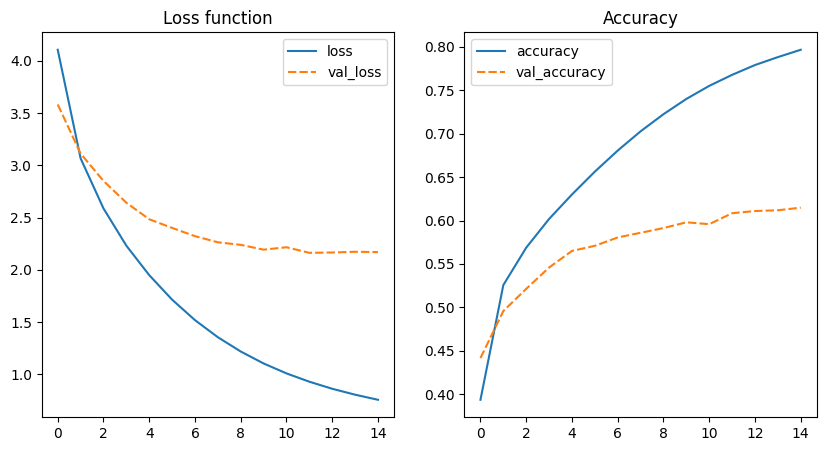

In [17]:
# Plot the learning curves (the loss function and the accuracy metric)
# which calculated on the training and validation datasets
_, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(data=df[['loss', 'val_loss']], ax=axs[0])
sns.lineplot(data=df[['accuracy', 'val_accuracy']], ax=axs[1])
axs[0].set_title('Loss function')
axs[1].set_title('Accuracy')
plt.show()

In [ ]:
# We can clearly see the overfitting process. To avoid overfitting we can do the next:
#  - Simplify the model (reduce the parameters number, add regularization layers)
#  - Increase amount of data

In [18]:
# Save weights
model_train.save_weights(base_path + 'Data/machine_translation_encoder_decoder_model_train_weights.h5')

# 4. Construct encoder and decoder for prediction

In [20]:
# Since the prediction process differs from the train we need to create two separate models: encoder and decoder
# Firstly, create the encoder model
model_encoder_prediction = Model(inputs=encoder_input, outputs=encoder_state)
model_encoder_prediction.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, None)]            0         
                                                                 
 encoder_embedding (Embeddi  (None, None, 64)          640000    
 ng)                                                             
                                                                 
 encoder_lstm (LSTM)         [(None, 128),             98816     
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
Total params: 738816 (2.82 MB)
Trainable params: 738816 (2.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
# model_encoder_prediction.load_weights(base_path + 'Data/machine_translation_encoder_model_prediction_weights.h5')

In [21]:
# Save weights
model_encoder_prediction.save_weights(base_path + 'Data/machine_translation_encoder_model_prediction_weights.h5')

In [19]:
# Secondly, connect decoder layers ...
decoder_output = decoder_net(decoder_input=decoder_input,
                             decoder_initial_state=[decoder_initial_h_state, decoder_initial_c_state])

In [22]:
# and create the decoder model (this decoder model isn't connected with the encoder model states)
model_decoder_prediction = Model(inputs=[decoder_input, decoder_initial_h_state, decoder_initial_c_state],
                                 outputs=decoder_output)
model_decoder_prediction.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 decoder_input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 decoder_embedding (Embeddi  (None, None, 64)             640000    ['decoder_input[0][0]']       
 ng)                                                                                              
                                                                                                  
 decoder_initial_h_state (I  [(None, None)]               0         []                            
 nputLayer)                                                                                       
                                                                                            

In [ ]:
# model_decoder_prediction.load_weights(base_path + 'Data/machine_translation_decoder_model_prediction_weights.h5')

In [23]:
# Save weights
model_decoder_prediction.save_weights(base_path + 'Data/machine_translation_decoder_model_prediction_weights.h5')

# 5. Make prediction



In [32]:
def predict(text: str) -> str:
  '''
    Make prediction
    :param text - string in source language
    :retrun string in target language
  '''
  # Make vectorization of the input string (make padded list of integer tokens)
  tokens = encoder_vec.predict([text])

  # Calculate the final hidden and cell states of the encoder LSTM cell by making the encoder model prediction
  encoder_state = model_encoder_prediction.predict(tokens)

  # Get max. length of the output phrase
  max_length = decoder_vec.max_length

  # Make a zeros template for the decoder input list of token
  decoder_input = np.zeros((1, max_length), dtype=np.int16)

  # Set the current token equal to the index of the start_token
  current_token = decoder_vec.vocabulary.index(START_TOKEN)

  # Set the token counter equal to 0
  count_tokens = 0

  # Set the output list of the words equal to the empty list
  output = []

  # Make prediction by the decoder LSTM cell until ether we get the end_token or achieve the maximum tokens count
  while current_token != decoder_vec.vocabulary.index(END_TOKEN) and count_tokens < max_length:

    # Add the current token to the decoder input
    decoder_input[0, count_tokens] = current_token

    # Compose the decoder inputs (input and the states from the encoder as initial states)
    x_data = {
        'decoder_input': decoder_input,
        'decoder_initial_h_state': encoder_state[0],
        'decoder_initial_c_state': encoder_state[1]
    }

    # Make decoder prediction and get the tokens sequence
    decoder_output = model_decoder_prediction.predict(x_data)

    # Get the last decoder output, find the maximum element (the element with the highest probability), and get its index
    current_token = np.argmax(decoder_output[0, count_tokens, :])

    # Increase token count
    count_tokens += 1

    # Get the word corresponds to the current index
    word = decoder_vec.vocabulary[current_token]

    output.append(word)

  # Join the list of words excluding the last token, since the last token is the end token.
  return ' '.join(output[:-1])

In [33]:
predict("i am going")

1/1 [==============================] - 0s 29ms/step


'я иду'